## Rewrite and re-train fully supervised NN on DL imagery
- Can't use old code because it was written for Torch 1.10, and DL supports up to 1.7

### Components: 
1. Dataloader
2. Neural net backbone
3. Training loop
4. Analytics/model logging

In [3]:
# try the imports
import os
import torch
import math
import numpy as np
import pandas as pd
import sys
import random
sys.path.append("../")
from tqdm.notebook import tqdm
sys.path.append('../UI_Labeling')
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import cv2

In [4]:
print(torch.__version__)

1.13.0+cu117


In [16]:
#Variables
model_name = "googletest_Upsampled_Train_n"

In [17]:
#Transformations
transformList=None
"""
transformList=transforms.RandomApply(torch.nn.ModuleList([
    transforms.ColorJitter(hue=.1,contrast=.25,saturation=.25,brightness=.25),
    transforms.RandomAffine(15),
]),p=.25)
#"""

'\ntransformList=transforms.RandomApply(torch.nn.ModuleList([\n    transforms.ColorJitter(hue=.1,contrast=.25,saturation=.25,brightness=.25),\n    transforms.RandomAffine(15),\n]),p=.25)\n#'

In [36]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device='cpu'
class Combo_BI_Dataset(Dataset):
    """
    Dataset for country/ies DL Sentinel2 10-channel imagery.
    """
    def __init__(self, DS_Name, balance=False, limit=0, mode="full",transform=None):
        super(Combo_BI_Dataset, self).__init__()
        self.df=pd.DataFrame()
        self.upsampled=True
        self.transform=transform
        
        def add_dataset(dataset_name):
            df=pd.read_csv("Image_Datasets/"+dataset_name+'/metadata.csv')
            if dataset_name == 'bangladesh_dl_dataset' or dataset_name == 'india_dl_dataset':
                self.upsampled=False
                
            if balance:
                confirmed={'Image':{},'Label':{},'Geometry':{}}
                denied={'Image':{},'Label':{},'Geometry':{}}
                for idx in df['Label'].keys():
                    if df['Label'][idx]:
                        confirmed['Image'][idx]=df['Image'][idx]
                        confirmed['Label'][idx]=df['Label'][idx]
                        confirmed['Geometry'][idx]=df['Geometry'][idx]
                    else:
                        denied['Image'][idx]=df['Image'][idx]
                        denied['Label'][idx]=df['Label'][idx]
                        denied['Geometry'][idx]=df['Geometry'][idx]
                        
                if limit:
                    random.seed(0)
                    sample_keys=random.sample(list(confirmed['Image'].keys()),min([len(confirmed['Image']),limit]))
                    confirmed={'Image':{},'Label':{},'Geometry':{}}
                    for idx in sample_keys:
                        confirmed['Image'][idx]=df['Image'][idx]
                        confirmed['Label'][idx]=df['Label'][idx]
                        confirmed['Geometry'][idx]=df['Geometry'][idx]
                random.seed(0)
                sample_keys=random.sample(list(denied['Image'].keys()),min([len(denied['Image']),math.ceil((len(confirmed['Image'])*3))]))
                denied={'Image':{},'Label':{},'Geometry':{}}
                for idx in sample_keys:
                    denied['Image'][idx]=df['Image'][idx]
                    denied['Label'][idx]=df['Label'][idx]
                    denied['Geometry'][idx]=df['Geometry'][idx]
                confirmed['Image'].update(denied['Image'])
                confirmed['Label'].update(denied['Label'])
                confirmed['Geometry'].update(denied['Geometry'])
                df=pd.DataFrame().from_dict(confirmed)
            #"""
            df["Image"]='Image_Datasets/'+dataset_name+'/'+df["Image"]
            df=df[['Image','Label']]
            return df
            
    # ADD DATASETS HERE FOR TRAINING
        
        self.df = pd.concat([self.df,add_dataset(DS_Name)])
        
    # END EDITABLES
        
        self.df = self.df.sample(frac=1, random_state=0)
        
        if mode == "tiny":
            self.df = self.df.sample(frac=.05, random_state=0)
        
    
    def __getitem__(self, idx):
        file_name, label = self.df.iloc[idx]
        img = torch.Tensor(np.load(file_name)/256).to(device)
        if self.transform:
            img=self.transform(img)
            img=img*256
        else:
            img=img*256
        img.int()
            
        label = torch.Tensor([label]).to(device)
        
        return img, label
        
        
    def __len__(self):
        return len(self.df)


In [31]:
from torchvision.models import resnet18
import torch.nn as nn

class Resnet(torch.nn.Module):
    def __init__(self, num_channels, image_width=64, device=None, pretrained=False):
        super(Resnet, self).__init__()
        self.device = device        
        self.resnet = resnet18(pretrained=pretrained)
        self.resnet.conv1 = torch.nn.Conv2d(num_channels, image_width, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 256).to(device)
        self.final_fc = torch.nn.Linear(256, 1).to(device)
        
        self.resnet = self.resnet.to(device)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        resnet_output = self.resnet(x)
        outputs = self.final_fc(resnet_output)
        outputs = self.sigmoid(outputs)
        return outputs
    

In [41]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch_iter, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(np.transpose(inputs,(0,3,1,2)))
        
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    
    return running_loss / batch_iter+1
        
        
def evaluate_model(model, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        all_labels = []
        all_preds = []
        all_outputs = []
        for batch_iter, (inputs, labels) in enumerate(val_loader):

            outputs = model(np.transpose(inputs,(0,3,1,2)))
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            outputs = outputs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = (outputs > .5).astype('int')
            
            all_labels.append(labels)
            all_preds.append(preds)
            all_outputs.append(outputs)
        
        all_labels = np.array([label for vec in all_labels for label in vec])
        all_preds = np.stack([pred for vec in all_preds for pred in vec])
        all_outputs = np.stack([output for vec in all_outputs for output in vec])
        val_acc = np.mean((all_labels == all_preds).astype('int'))
            
    return val_acc, running_loss / batch_iter+1, all_labels, all_outputs

def save_checkpoint(logdir, model, optimizer, epoch, loss, lr, best=None,last=None):
    """
    Saves model checkpoint after each epoch
    logdir: Log directory
    model: model to save
    optimizer: optimizer to save
    epoch: epoch to save on
    loss: loss to log
    lr: learning rate to log
    best: An optional string used to specify which validation method this best
    checkpoint is for
    """
    checkpoint_dir = os.path.join(logdir, "checkpoints")
    os.makedirs(checkpoint_dir, exist_ok=True)
    if best:
        print(f"Saving checkpoint, {best}.")
        checkpoint_path = "{}/best_{}.pth".format(checkpoint_dir, best)
    elif last:
        print(f"Saving last, {last}.")
        checkpoint_path = "{}/last_{}.pth".format(checkpoint_dir,last)
    else:
        checkpoint_path = "{}/lr{}_epoch{}.pth".format(checkpoint_dir, lr, epoch)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, checkpoint_path)

    if not best:
        print("Saving checkpoint to lr{}_epoch{}".format(lr, epoch))
        

def load_checkpoint(model_checkpoint, model, device, optimizer=None):
    """
    Loads a pretrained checkpoint to continue training
    model_checkpoint: Path of the model_checkpoint that ends with .pth
    model: model to load to
    device: devide to load on (gpu/cpu)
    optimizer (optional): optimize to load state to
    """
    checkpoint = torch.load(model_checkpoint, map_location=device)
    print('Loaded best state dict from epoch: {}'.format(checkpoint["epoch"]))
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    return model

In [42]:
dataset=[]
train_dset=None
val_dset=None
#Commend or uncomment for datasets you'd like to add.
dataset.append(Combo_BI_Dataset('googletest_state_sampled_nepal_dl_dataset',True,702,transform=transformList))
#dataset.append(Combo_BI_Dataset('Upsampled_india_dl_dataset',True,858,transform=transformList))
#dataset.append(Combo_BI_Dataset('v2_Upsampled_high_sampled_india_dl_dataset',True,858,transform=transformList))
#dataset.append(Combo_BI_Dataset('v2_Upsampled_updatedModel_state_sampled_pakistan_dl_dataset',True,858,transform=transformList))
#dataset.append(Combo_BI_Dataset('v2_Upsampled_updatedModel_state_sampled_nepal_dl_dataset',True,858,transform=transformList))

for dset in dataset:
    train, val = torch.utils.data.random_split(
        dset, 
        [len(dset)*8//10, len(dset)-len(dset)*8//10], # 80-10% split
        generator=torch.Generator().manual_seed(0)
    )
    if train_dset is None and val_dset is None:
        train_dset=train
        val_dset=val
    else:
        train_dset=torch.utils.data.ConcatDataset([train_dset,train])
        val_dset=torch.utils.data.ConcatDataset([val_dset,val])
print(f"{len(train_dset)} training examples and {len(val_dset)} validation examples.")
train_loader = DataLoader(train_dset, batch_size=64,shuffle=True)
val_loader = DataLoader(val_dset, batch_size=64,shuffle=True)

268 training examples and 68 validation examples.


In [43]:
# let's give it a whirl

# some things to try for speedups:
# torch.cuda.empty_cache()
# change number of workers, use detach instead of just 
N_EPOCHS = 50
model = Resnet(3, device=device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

best_val_loss = None

logdir = "model_log_dl/"+model_name+"_50_training_steps/"


## BUFFER

In [44]:
early_stop=0
if not os.path.exists(logdir):
    os.mkdir(logdir)

for epoch in tqdm(range(N_EPOCHS)):
    if early_stop >= 7:
        print('Early stopping!')
        break;
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_loss, _, _ = evaluate_model(model, val_loader)
    
    print(f"Train_loss: {train_loss:.6f}, Val-acc: {val_acc:.5f}, Val-loss: {val_loss:.5f}")
    
    if epoch > 5 and (best_val_loss is None or val_loss < best_val_loss):
        early_stop = 0
        best_val_loss = val_loss
        print("Best val loss, saving checkpoint!")
        save_checkpoint(logdir, model, optimizer, epoch, val_loss, lr, best="dl_best")
    elif epoch > 5 and (val_loss >= best_val_loss*1.1):
        early_stop+=1
    if epoch % 12 == 0:
        save_checkpoint(logdir, model, optimizer, epoch, val_loss, lr)
    print('Early Stop:',early_stop,'/7')
print('Done!')

  0%|          | 0/50 [00:00<?, ?it/s]

Train_loss: 0.648717, Val-acc: 0.75000, Val-loss: 2.31341
Saving checkpoint to lr0.0001_epoch0
Early Stop: 0 /7
Train_loss: 0.396677, Val-acc: 0.79412, Val-loss: 1.14866
Early Stop: 0 /7
Train_loss: 0.294976, Val-acc: 0.85294, Val-loss: 0.35371
Early Stop: 0 /7
Train_loss: 0.371795, Val-acc: 0.88235, Val-loss: 0.35705
Early Stop: 0 /7
Train_loss: 0.333496, Val-acc: 0.85294, Val-loss: 0.78215
Early Stop: 0 /7
Train_loss: 0.274958, Val-acc: 0.91176, Val-loss: 0.26163
Early Stop: 0 /7
Train_loss: 0.251050, Val-acc: 0.83824, Val-loss: 0.39462
Best val loss, saving checkpoint!
Saving checkpoint, dl_best.
Early Stop: 0 /7
Train_loss: 0.247784, Val-acc: 0.88235, Val-loss: 0.39662
Early Stop: 0 /7
Train_loss: 0.218613, Val-acc: 0.88235, Val-loss: 0.42815
Early Stop: 0 /7
Train_loss: 0.235103, Val-acc: 0.88235, Val-loss: 0.28202
Best val loss, saving checkpoint!
Saving checkpoint, dl_best.
Early Stop: 0 /7
Train_loss: 0.212472, Val-acc: 0.88235, Val-loss: 0.56634
Early Stop: 1 /7
Train_loss: 0.

In [45]:
save_checkpoint(logdir, model, optimizer, epoch, val_loss, lr,last='dl_last')

Saving last, dl_last.
Saving checkpoint to lr0.0001_epoch34


## BUFFER

In [46]:
#let's test this bad boy
best_val_model = Resnet(3, device=device)
final_epoch_model = Resnet(3, device=device)

best_val_model = load_checkpoint(f"{logdir}/checkpoints/best_dl_best.pth", 
                                 best_val_model, 
                                 device)
#best_val_model = load_checkpoint('kiln_prod_weights.pth',best_val_model,device)
final_epoch_model = load_checkpoint(f"{logdir}/checkpoints/last_dl_last.pth", 
                                    final_epoch_model, 
                                    device)

#final_epoch_model = load_checkpoint(f"{logdir}/checkpoints/lr0.0001_epoch49.pth", 
#                                    final_epoch_model, 
#                                    device)


Loaded best state dict from epoch: 25
Loaded best state dict from epoch: 34


In [47]:
best_val_acc, best_val_loss, best_labels, best_outputs = evaluate_model(best_val_model, 
                                                                        val_loader)
final_val_acc, final_val_loss, final_labels, final_outputs = evaluate_model(final_epoch_model, 
                                                                            val_loader)


In [48]:
print('Best:',best_val_acc, best_val_loss)
print('Last:',final_val_acc, final_val_loss)

Best: 0.9117647058823529 0.17421196741634049
Last: 0.8970588235294118 0.31351378187537193


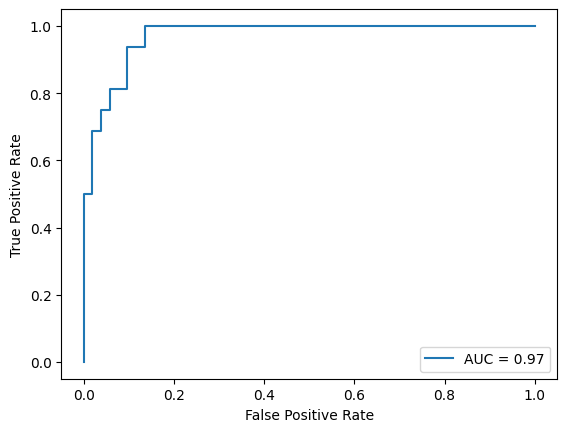

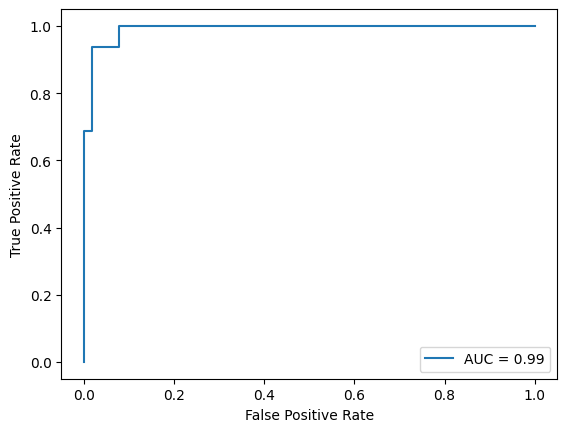

In [49]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# val_roc = roc_auc_score(best_labels, best_outputs)
# final_roc = roc_auc_score(final_labels, final_outputs)

final_fpr, final_tpr, final_thresholds = metrics.roc_curve(final_labels, final_outputs)
final_roc_auc = metrics.auc(final_fpr, final_tpr)
display = metrics.RocCurveDisplay(fpr=final_fpr, tpr=final_tpr, roc_auc=final_roc_auc)
display.plot()
# plt.show()

best_fpr, best_tpr, best_thresholds = metrics.roc_curve(best_labels, best_outputs)
best_roc_auc = metrics.auc(best_fpr, best_tpr)
display = metrics.RocCurveDisplay(fpr=best_fpr, tpr=best_tpr, roc_auc=best_roc_auc)
display.plot()

In [50]:
print('Best:',best_roc_auc)
print('Last:',final_roc_auc)


Best: 0.9903846153846154
Last: 0.9699519230769231


## BUFFER

In [20]:
print('hi')

hi
